In [1]:
from pymongo import MongoClient

import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
database  = MongoClient()["scraper2"]
movements = database["container_movements"]
statuses  = database["statuses"]

In [3]:
select = {
    "container": 1,
    "date": 1,
    "location": 1,
    "latitude": 1,
    "longitude": 1,
    "status": 1,
    "estimated": 1,
    "transport_type": 1
}

In [4]:
def preprocess(movements, carrier):
    for movement in movements:
        # Vehicle type as number
        if ("vehicle" not in movement) or (movement["vehicle"] == 0):
            if movement["transport_type"] == "Vessel":
                movement["vehicle"] = 1
            elif movement["transport_type"] == "Truck":
                movement["vehicle"] = 2
            elif movement["transport_type"] == "Train":
                movement["vehicle"] = 3
            else:
                movement["vehicle"] = 0
        # Status type as number
        if ("status_code" not in movement) or (movement["status_code"] == 0):
            status = statuses.find_one({carrier: movement["status"]})
            movement["status_code"] = int(status["code"]) if status else 0
    return movements

## Maersk

In [5]:
maersk_query = {
    "container": "MRKU5264777"
}

cursor = movements.find(maersk_query, select).sort("date", 1)
maersk = preprocess(list(cursor), "Maersk")

print(len(maersk))

9


In [6]:
maersk_df = pd.DataFrame(maersk).drop("_id", axis = 1)
maersk_df

,container,date,estimated,latitude,location,longitude,status,status_code,transport_type,vehicle
0,MRKU5264777,2019-02-12 18:32:00,False,3.002762,Cogent Container Depot (M) Sdn Bhd\nPort Klang...,101.396674,Empty,1,Truck,2
1,MRKU5264777,2019-02-13 21:35:00,False,3.002762,"Westport\nPort Klang, Selangor, Malaysia",101.396674,Gate in,2,Truck,2
2,MRKU5264777,2019-02-15 01:13:00,False,3.002762,"Westport\nPort Klang, Selangor, Malaysia",101.396674,Load,3,Vessel,1
3,MRKU5264777,2019-02-21 02:57:00,False,22.350627,Hongkong/Hk International Terminals\nHong Kong...,114.184916,Discharge,7,Vessel,1
4,MRKU5264777,2019-02-24 15:17:00,False,22.350627,Hongkong/Hk International Terminals\nHong Kong...,114.184916,Gate out,8,Truck,2
5,MRKU5264777,2019-02-24 15:29:00,False,22.350627,"Hong Kong Modern Terminals Ltd\nHong Kong, Hon...",114.184916,Gate in,2,Truck,2
6,MRKU5264777,2019-03-05 15:51:00,False,22.350627,"Hong Kong Modern Terminals Ltd\nHong Kong, Hon...",114.184916,Load,3,Vessel,1
7,MRKU5264777,2019-04-05 23:29:00,False,-12.066667,"APM Terminals in Callao Port\nCallao, Peru",-77.150000,Discharge,7,Vessel,1
8,MRKU5264777,2019-04-06 14:11:00,False,-12.066667,"APM Terminals in Callao Port\nCallao, Peru",-77.150000,Gate out,8,Truck,2


## Hapag-Lloyd

In [18]:
hapag_query = {
    "container": "FSCU5670046"
}

cursor = movements.find(hapag_query, select).sort("date", 1)
hapag = preprocess(list(cursor), "Hapag-Lloyd")

print(len(hapag))

7


In [19]:
hapag_df = pd.DataFrame(hapag).drop("_id", axis = 1)
hapag_df

,container,date,estimated,latitude,location,longitude,status,status_code,transport_type,vehicle
0,FSCU5670046,2019-03-12 07:33:00,False,51.221110,ANTWERP,4.399708,Gate out empty,1,Truck,2
1,FSCU5670046,2019-03-12 14:37:00,False,51.221110,ANTWERP,4.399708,Arrival in,2,Truck,2
2,FSCU5670046,2019-03-26 12:59:00,False,51.221110,ANTWERP,4.399708,Loaded,3,Vessel,1
3,FSCU5670046,2019-03-26 21:54:00,False,51.221110,ANTWERP,4.399708,Vessel departed,4,Vessel,1
4,FSCU5670046,2019-04-07 03:30:00,False,36.846292,"NORFOLK, VA",-76.292925,Vessel arrived,5,Vessel,1
5,FSCU5670046,2019-04-07 09:25:00,False,36.846292,"NORFOLK, VA",-76.292925,Discharged,7,Vessel,1
6,FSCU5670046,2019-04-09 16:49:00,False,36.846292,"NORFOLK, VA",-76.292925,Departure from,8,Truck,2


## Evergreen

In [21]:
evergreen_query = {
    "container": "EGSU9089973"
}

cursor = movements.find(evergreen_query, select).sort("date", 1)
evergreen = preprocess(list(cursor), "Evergreen")

print(len(evergreen))

3


In [22]:
evergreen_df = pd.DataFrame(evergreen).drop("_id", axis = 1)
evergreen_df

,container,date,estimated,latitude,location,longitude,status,status_code,transport_type,vehicle
0,EGSU9089973,2019-03-07,False,-12.066667,CALLAO (PE),-77.150000,Loaded (FCL) on vessel,3,Vessel,1
1,EGSU9089973,2019-04-10,False,22.350627,HONG KONG (HK),114.184916,Despatched by barge,9,Vessel,1
2,EGSU9089973,2019-04-11,False,23.182451,"HUANGPU, GUANGDONG (CN)",113.476086,Discharged (FCL),7,Vessel,1


## Línea de tiempo

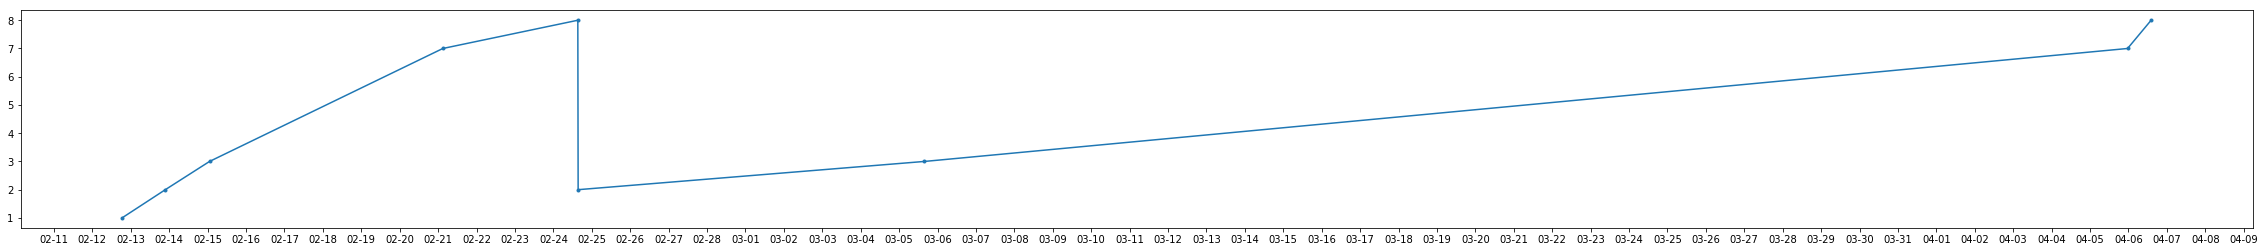

In [11]:
plt.figure(figsize = (40, 4))
[timeline] = plt.plot(maersk_df["date"], maersk_df["status_code"], marker = ".")

xaxis = timeline.axes.xaxis
xaxis.set_major_locator(mdates.DayLocator())
xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

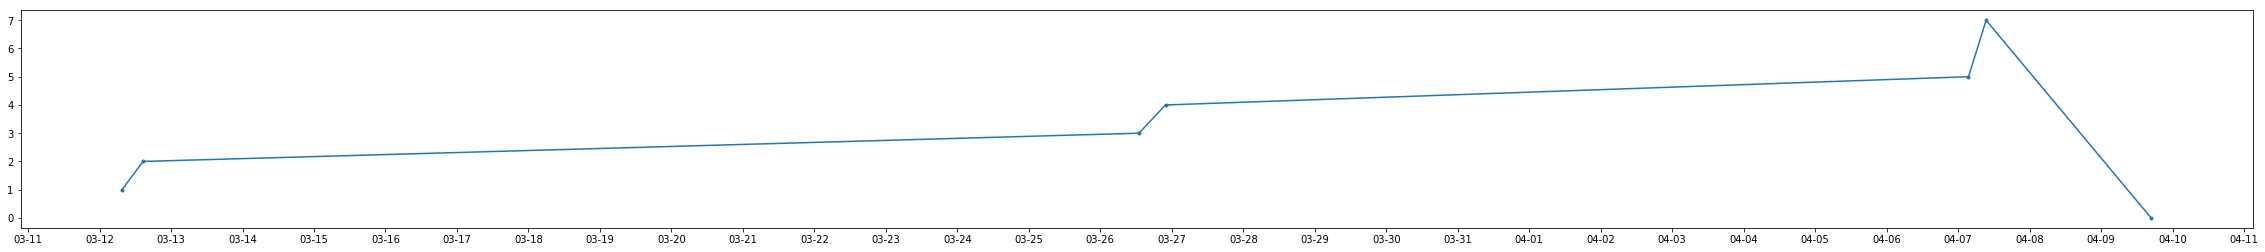

In [12]:
plt.figure(figsize = (40, 4))
[timeline] = plt.plot(hapag_df["date"], hapag_df["status_code"], marker = ".")

xaxis = timeline.axes.xaxis
xaxis.set_major_locator(mdates.DayLocator())
xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

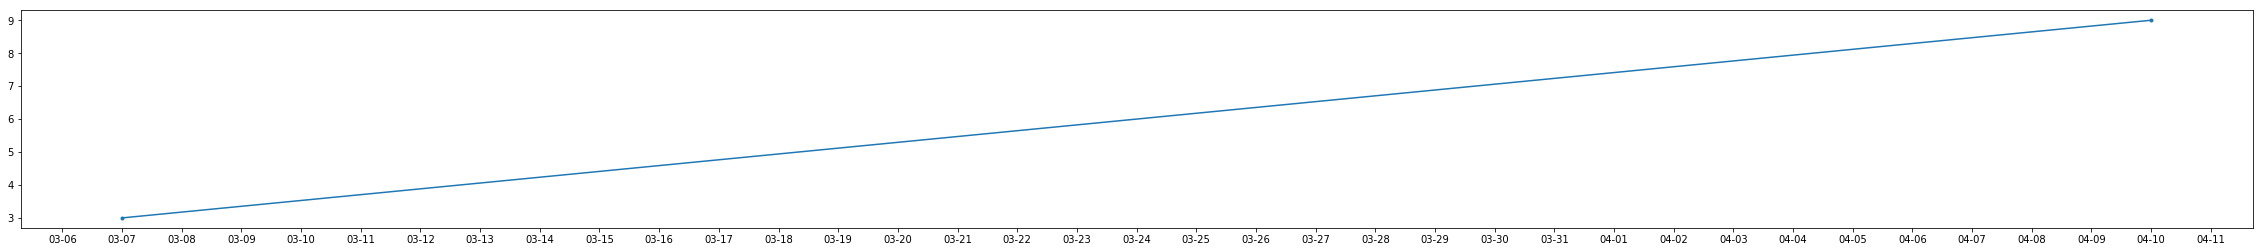

In [13]:
plt.figure(figsize = (40, 4))
[timeline] = plt.plot(evergreen_df["date"], evergreen_df["status_code"], marker = ".")

xaxis = timeline.axes.xaxis
xaxis.set_major_locator(mdates.DayLocator())
xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

## Mapa

In [14]:
class TrackingMap:
    """Map generator for the Container Tracking project."""
    
    COLORS  = ["b", "r", "g", "m", "y"]
    FIGSIZE = (15, 8)
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.origin  = None
        self.destiny = None
        self.counter = 0
    
    def show(self, filename = None):
        # Set figure size
        plt.figure(figsize = self.FIGSIZE)
        # Generate axes
        ax = plt.axes(projection = ccrs.PlateCarree())
        ax.stock_img()
        # Iterate rows and plot points
        for index, row in self.dataset.iterrows():
            self.plot_points(row)
        # Plot last label
        if self.destiny is not None:
            self.plot_label(self.destiny)
        # Show plot
        plt.show()
    
    def plot_points(self, row):
        # Get destiny location
        self.destiny = self.get_coordinates(row)
        # Set first origin location, if necessary
        if self.origin is None:
            self.origin = self.destiny
        # Compare locations
        if self.origin != self.destiny:
            # Plot curves and lines
            longitudes = [self.origin[1], self.destiny[1]]
            latitudes  = [self.origin[0], self.destiny[0]]
            self.plot_curves(longitudes, latitudes, self.COLORS[self.counter])
            # Print label for origin point
            self.plot_label(self.origin)
            # Set variables for next iteration
            self.origin  = self.destiny
            self.counter = self.counter + 1 if self.counter < (len(self.COLORS) - 1) else 0
        
    def plot_curves(self, longitudes, latitudes, color):
        # Plot geodetic curve
        plt.plot(longitudes, latitudes, color = color, linewidth = 2, marker = "o", transform = ccrs.Geodetic())
        # Plot straight line
        plt.plot(longitudes, latitudes, color = "gray", linestyle = "--", transform = ccrs.PlateCarree())
    
    def plot_label(self, coord):
        plt.text(coord[1] - 3, coord[0] - 6, coord[2], horizontalalignment = "right", transform = ccrs.Geodetic())
    
    def get_coordinates(self, row):
        location = row["location"].split("\n")[-1]
        return (row["latitude"], row["longitude"], location)

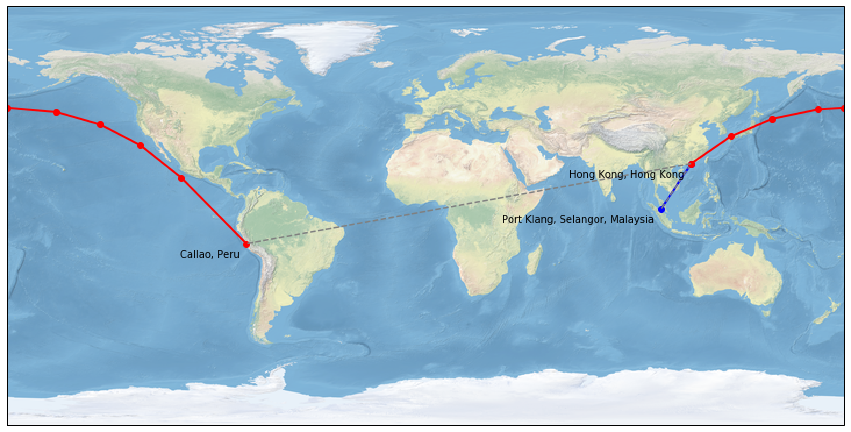

In [15]:
TrackingMap(maersk_df).show()

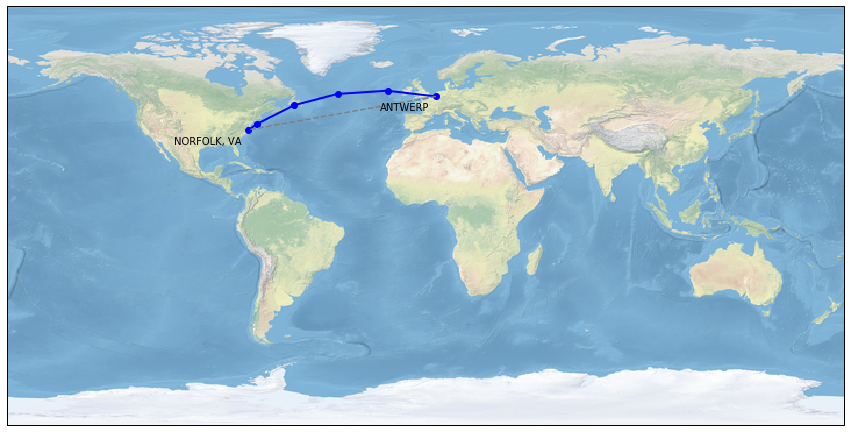

In [16]:
TrackingMap(hapag_df).show()

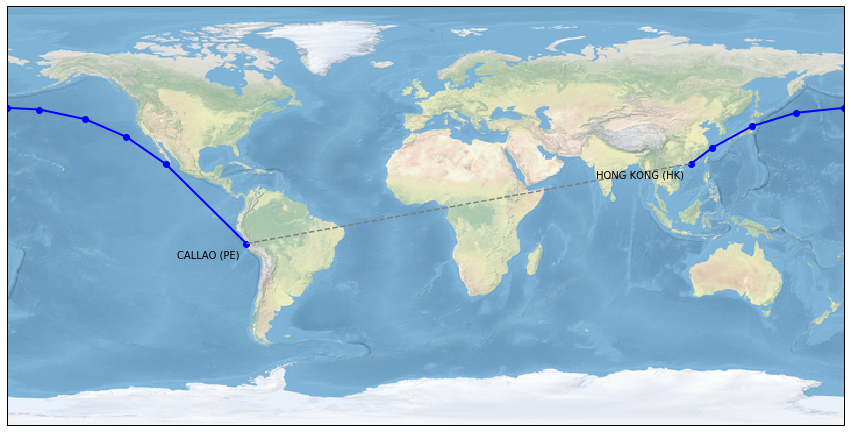

In [17]:
TrackingMap(evergreen_df).show()